# Assignment - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [1]:
# stundent details example: John S. 9812
#                       student details 1: Ariel E 2196
# (if exists)           student details 2: Barak P 6887
# (if exists)           student details 3: 
# (if exists)           student details 4: 

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name: ChatGPT 
Goal: ML on packet anomaly
Prompt1:
I have a project in ML, this is the requirements for this project. can you help me understand them properlly? order the flow by steps and  design a road map for it. I want to go with the cyber security application

Prompt2:
based on the sources i gave you, i want to start with Phase 1 of the project. lets do the data and EDA process - dont forget to explain each step properly

Prompt3: 
OK the EDA looks good and well explained. Lets move to phase 2, remember to keep on this behavior and be very thorough in the experiments.

Prompt4: 
lets continue to step 4 & 5 
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

## Learning Problem & Dataset Explanation

**Problem type:** Supervised **multi-class classification** for cyber-security.  
**Goal:** Given per-packet/flow features, predict the network event label:
- `no_anomaly` (benign)
- `suspicious` (potential issue)
- `anomaly` (malicious/attack)

We frame this as an IDS (Intrusion Detection) baseline on tabular data.

---

### Dataset & Splits
We work with **pre-split** CSVs provided by the course:
- **`packets_train.csv`** — used for *EDA* and *model selection* (via 5-fold Stratified CV).
- **`packets_test.csv`** — held-out set used **once** for final evaluation.

> We **do not re-split** the data; we honor the given train/test split.

**Sizes & shape (from EDA):**
- Train: **9,600 rows × 10 columns**
- Test: **2,400 rows × 10 columns**

**Schema (typical columns):**
- Numeric: e.g., `timestamp`, `packet_length`, `ttl`
- Categorical: e.g., `protocol`, `src_ip`, `dst_ip`
- Binary flags: e.g., `tcp_syn`, `tcp_ack`, `tcp_fin`
- Target label: **`label`** ∈ {`no_anomaly`, `suspicious`, `anomaly`}

**Label distribution (train):** highly imbalanced  
- `no_anomaly` ≈ **99.23%**  
- `suspicious` ≈ **0.47%**  
- `anomaly` ≈ **0.30%**

This imbalance strongly influences our metric choice and experimental design.

---

### What the Model Learns From
Each row is a packet/flow record with transport/network features (protocol, TTL, sizes, TCP flags) and endpoints/timestamps.  
We treat IPs as categorical identifiers (or derive simple encodings); we may drop `timestamp` in some configurations to avoid temporal leakage.

---

### Evaluation Metric & Rationale
- **Primary metric:** **Macro-F1** (averages F1 across classes).  
  *Why?* Accuracy would be misleading under extreme imbalance; Macro-F1 gives equal weight to minority classes.

---

### Preprocessing & Experiment Plan (summary)
- **EDA:** sanity-check schema, missingness (none observed), distributions, correlations.
- **Feature engineering:** one-hot for categoricals; scaling for numerics (Standard/MinMax); optional feature selection; optional dropping of `timestamp`.
- **Modeling:** compare Logistic Regression, Linear SVM, Random Forest with class weighting; search hyper-parameters.
- **Validation:** **5-fold Stratified CV** with **GridSearchCV**, scored by **Macro-F1**; select best configuration.
- **Finalization:** retrain best pipeline on **all train**; evaluate **once** on **test**; report Macro-F1, per-class report, confusion matrix, and first 5 predictions.

---

### Assumptions & Risks
- **Imbalance:** We mitigate via class-weighted learners and Macro-F1. (If allowed, future work may try resampling within CV.)
- **Leakage caution:** avoid using fields that trivially encode the target or split (e.g., timestamps tied to attack windows) without justification.
- **Reproducibility:** fixed `random_state`, pipeline-based preprocessing to prevent train/test leakage.

# Phase 1 — Data Loading & EDA (Cyber Packet Anomalies)

**Goal:** load the provided train/test CSVs *as-is*, preview them, identify the target label, and perform 3–4+ EDA visuals with short explanations — exactly as required by the assignment (show first 5 rows; no re-splitting).

**Deliverables in this section**
- Heads of train/test
- Schema & missingness summary
- Label discovery & class balance
- EDA visuals: histograms (top-variance features), correlation heatmap, class-conditioned boxplot


In [35]:
# Core libraries only (allowed by assignment)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import parallel_backend
# Modeling
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
from sklearn.model_selection import cross_val_predict
from sklearn.base import clone

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)


RANDOM_STATE = 42


# Matplotlib display defaults
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# Paths
TRAIN_PATH = "packets_train.csv"
TEST_PATH  = "packets_test.csv"

# Helper: pretty printing
def hr(title=""):
    print("\n" + "="*10 + f" {title} " + "="*10 + "\n")


In [15]:
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

hr("Shapes")
print(f"Train shape: {train.shape}")
print(f"Test  shape: {test.shape}")

hr("Train – first 5 rows")
display(train.head(5))

hr("Test – first 5 rows")
display(test.head(5))



========== Shapes ==========

Train shape: (9600, 10)
Test  shape: (2400, 10)

========== Train – first 5 rows ==========



,timestamp,src_ip,dst_ip,protocol,ttl,packet_length,tcp_syn,tcp_ack,tcp_fin,label
0,1700000828,192.168.0.21,10.0.1.54,UDP,117,1046,0,0,0,no_anomaly
1,1700002005,192.168.1.37,10.0.6.187,TCP,41,405,0,0,0,no_anomaly
2,1700000143,192.168.2.248,10.0.5.239,TCP,91,799,0,1,0,no_anomaly
3,1700002333,192.168.2.174,10.0.2.83,UDP,116,851,0,0,0,no_anomaly
4,1700000913,192.168.1.223,10.0.4.54,TCP,32,902,1,0,0,no_anomaly



========== Test – first 5 rows ==========



,timestamp,src_ip,dst_ip,protocol,ttl,packet_length,tcp_syn,tcp_ack,tcp_fin,label
0,1700002175,192.168.2.238,10.0.2.45,TCP,59,1230,1,0,0,no_anomaly
1,1700001578,192.168.3.189,10.0.7.120,ICMP,70,1169,0,0,0,no_anomaly
2,1700001252,192.168.0.223,10.0.2.69,TCP,105,827,0,1,0,no_anomaly
3,1700000848,192.168.1.135,10.0.1.93,TCP,80,742,0,0,0,no_anomaly
4,1700001491,192.168.2.67,10.0.3.170,TCP,113,1273,0,0,0,no_anomaly


In [16]:
# Find the label column for generic usage :)

def guess_label_column(df: pd.DataFrame) -> str | None:
    # Prefer a column literally named 'label' (any case)
    exact = [c for c in df.columns if c.lower() == "label"]
    if exact:
        return exact[0]
    # Otherwise look for likely names
    priority = ['label', 'attack', 'anomaly', 'is_anomaly', 'malicious', 'class', 'target', 'y']
    cands = [c for c in df.columns if any(k in c.lower() for k in priority)]
    if cands:
        uniq_counts = {c: df[c].nunique(dropna=True) for c in cands}
        return sorted(cands, key=lambda c: uniq_counts[c])[0]
    # Fallback: low-cardinality columns (<=10 unique)
    few = [c for c in df.columns if df[c].nunique(dropna=True) <= 10]
    for c in few:
        if (pd.api.types.is_bool_dtype(df[c])
            or pd.api.types.is_integer_dtype(df[c])
            or pd.api.types.is_object_dtype(df[c])):
            return c
    return None

label_col = guess_label_column(train)
hr("Detected label column")
print(label_col if label_col is not None else "None detected — set it manually, e.g., label_col = 'label'")

if label_col is not None:
    vc = train[label_col].value_counts(dropna=False)
    pct = (vc / len(train) * 100).round(2)
    class_summary = pd.DataFrame({"count": vc, "percent": pct})
    hr(f"Label distribution (train) — '{label_col}'")
    display(class_summary)



========== Detected label column ==========

label

========== Label distribution (train) — 'label' ==========



,count,percent
label,,
no_anomaly,9526,99.23
suspicious,45,0.47
anomaly,29,0.30


In [17]:
def summarize_schema(df: pd.DataFrame, name: str):
    n_rows, n_cols = df.shape
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in df.columns if c not in num_cols]
    total_missing = int(df.isna().sum().sum())
    miss_pct = (100 * total_missing / (n_rows * n_cols)) if n_rows*n_cols else 0.0
    summary = pd.DataFrame({
        "dataset": [name],
        "rows": [n_rows],
        "columns": [n_cols],
        "numeric_cols": [len(num_cols)],
        "categorical_cols": [len(cat_cols)],
        "missing_cells": [total_missing],
        "missing_pct": [round(miss_pct, 3)]
    })
    return summary, num_cols, cat_cols

train_summary, train_num_cols, train_cat_cols = summarize_schema(train, "train")
test_summary,  test_num_cols,  test_cat_cols  = summarize_schema(test,  "test")
combined_summary = pd.concat([train_summary, test_summary], ignore_index=True)

hr("Dataset summaries (rows/cols/dtypes/missingness)")
display(combined_summary)

hr("Train — top 15 columns by missing%")
missing_pct = (train.isna().mean() * 100.0).sort_values(ascending=False)
display(missing_pct.head(15).round(2).to_frame(name="missing_pct"))

hr("Type split (train)")
print(f"Numeric columns:    {len(train_num_cols)}")
print(f"Categorical columns:{len(train_cat_cols)}")



========== Dataset summaries (rows/cols/dtypes/missingness) ==========



,dataset,rows,columns,numeric_cols,categorical_cols,missing_cells,missing_pct
0,train,9600,10,6,4,0,0.0
1,test,2400,10,6,4,0,0.0



========== Train — top 15 columns by missing% ==========



,missing_pct
timestamp,0.0
src_ip,0.0
dst_ip,0.0
protocol,0.0
ttl,0.0
packet_length,0.0
tcp_syn,0.0
tcp_ack,0.0
tcp_fin,0.0
label,0.0



========== Type split (train) ==========

Numeric columns:    6
Categorical columns:4


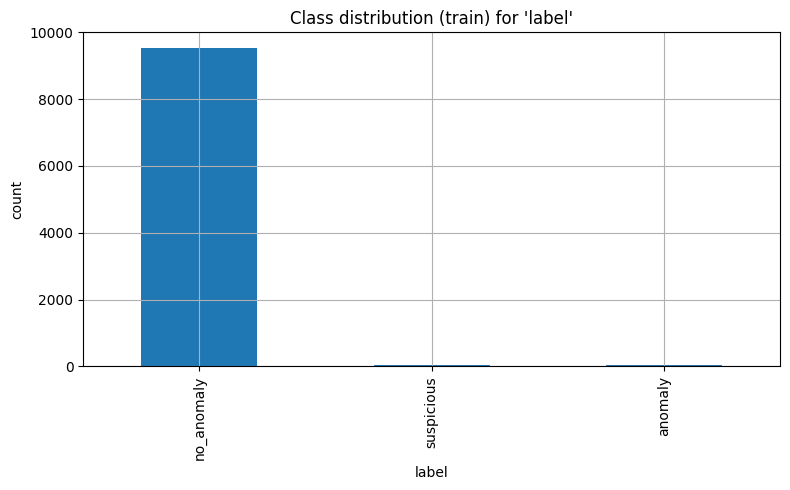

Explanation:
- We observe strong class imbalance. In later phases we'll use Macro-F1 and class-aware strategies.


In [18]:
if label_col is None:
    print("No label column detected; skip this cell or set label_col manually.")
else:
    plt.figure()
    train[label_col].value_counts(dropna=False).plot(kind="bar")
    plt.title(f"Class distribution (train) for '{label_col}'")
    plt.xlabel(label_col)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    print("Explanation:")
    print("- We observe strong class imbalance. In later phases we'll use Macro-F1 and class-aware strategies.")


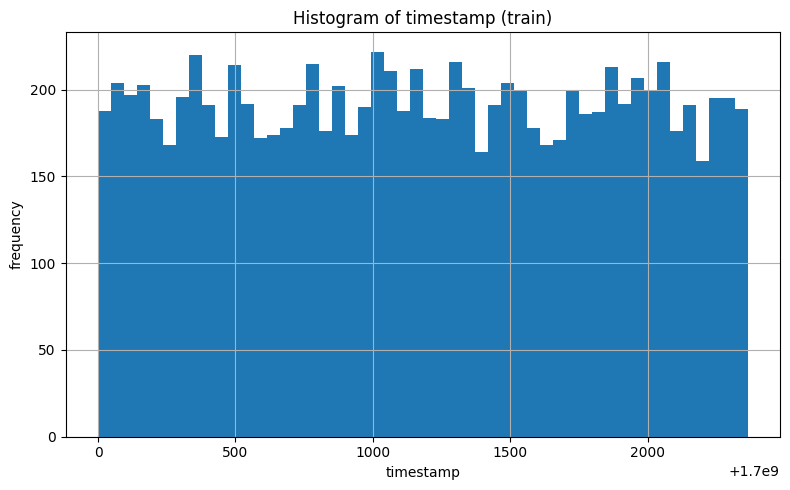

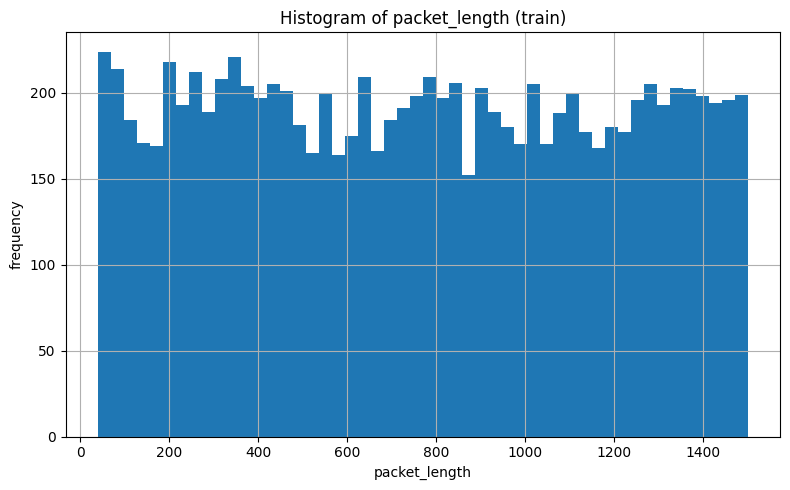

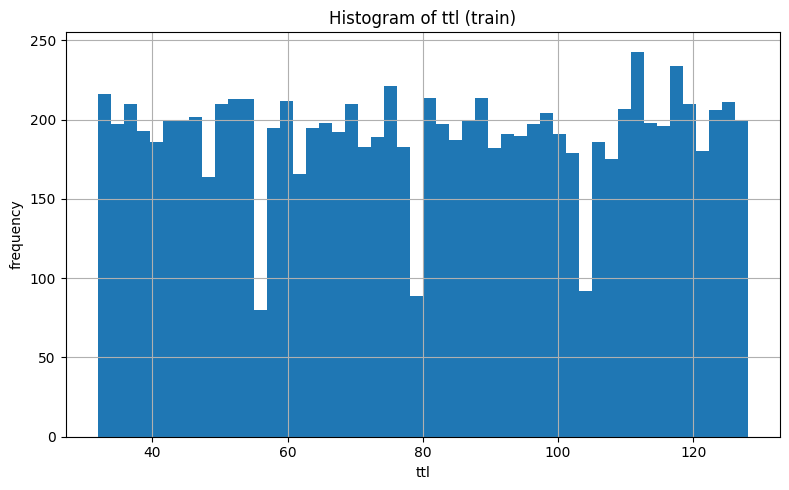

Explanation:
- Histograms show range/outliers/heavy tails and tell us if scaling will help downstream models.


In [19]:
if train_num_cols:
    # Pick up to 3 most variable numeric features (ignoring NaNs)
    variances = train[train_num_cols].var(numeric_only=True).sort_values(ascending=False)
    top3_hist_cols = variances.index.tolist()[:3]

    for col in top3_hist_cols:
        plt.figure()
        train[col].dropna().hist(bins=50)
        plt.title(f"Histogram of {col} (train)")
        plt.xlabel(col)
        plt.ylabel("frequency")
        plt.tight_layout()
        plt.show()

    print("Explanation:")
    print("- Histograms show range/outliers/heavy tails and tell us if scaling will help downstream models.")
else:
    print("No numeric columns found for histograms.")


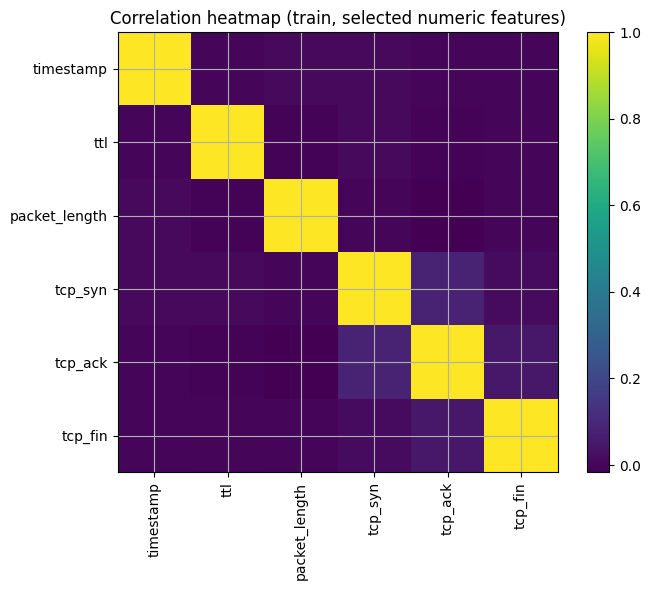

Explanation:
- Strongly correlated features may be redundant; this informs feature selection/regularization.


In [20]:
num_cols_for_corr = train_num_cols[:12]  # cap for readability
if len(num_cols_for_corr) >= 2:
    corr = train[num_cols_for_corr].corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    im = plt.imshow(corr, interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(num_cols_for_corr)), num_cols_for_corr, rotation=90)
    plt.yticks(range(len(num_cols_for_corr)), num_cols_for_corr)
    plt.title("Correlation heatmap (train, selected numeric features)")
    plt.tight_layout()
    plt.show()

    print("Explanation:")
    print("- Strongly correlated features may be redundant; this informs feature selection/regularization.")
else:
    print("Not enough numeric features for a correlation heatmap.")


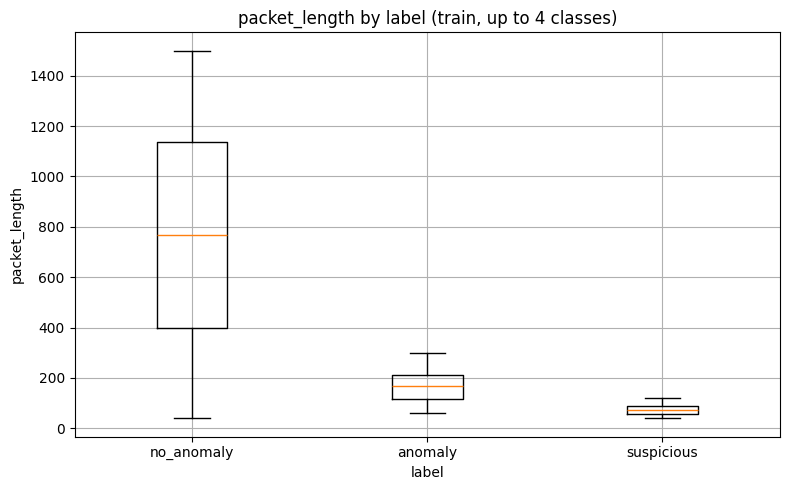

Explanation:
- Boxplot compares distribution of 'packet_length' across classes; visible shifts suggest separability.


In [21]:

if (label_col is not None) and train_num_cols:
    # choose a high-variance numeric feature
    variances = train[train_num_cols].var(numeric_only=True).sort_values(ascending=False)
    box_feat = variances.index.tolist()[1]
    classes = list(train[label_col].dropna().unique())  # limit for readability
    vals = [train.loc[train[label_col] == cl, box_feat].dropna().values for cl in classes]
    labels = [str(cl) for cl in classes]

    if any(len(v) for v in vals):
        plt.figure()
        plt.boxplot(vals, tick_labels=labels, showfliers=False)
        plt.title(f"{box_feat} by {label_col} (train, up to 4 classes)")
        plt.xlabel(label_col)
        plt.ylabel(box_feat)
        plt.tight_layout()
        plt.show()

        print("Explanation:")
        print(f"- Boxplot compares distribution of '{box_feat}' across classes; visible shifts suggest separability.")
    else:
        print("Selected feature/classes had no values to plot.")
else:
    print("Need a detected label and at least one numeric feature to draw this plot.")



### Phase 1 Conclusions
- **Task:** Multi-class classification (`label` with classes such as `no_anomaly`, `suspicious`, `anomaly`).
- **Data quality:** No missing values detected; ~6 numeric and ~4 categorical features.
- **Imbalance:** `no_anomaly` dominates → will optimize **Macro-F1** and apply class-aware strategies in CV.
- **Distributions & correlations:** Numeric features show varied scales (we’ll add scaling); correlation heatmap suggests some redundancy → feature selection/regularization may help.
- **Next (Phase 2):** Build pipelines that try (scaling × simple feature selection) × (tabular models) with **5-fold CV** and **grid/grid-like search**, scored by **Macro-F1**.


# Phase 3 — Experiments: Feature Engineering × Models × Hyperparams

**Goal**: Run thorough experiments using 5-fold Stratified CV and a grid-search over:
- Preprocessing: optional timestamp drop; scaling = {Standard, MinMax, None}; feature selection = SelectPercentile {100, 50, 25}.
- Models: Logistic Regression (balanced), LinearSVC (balanced), RandomForest (balanced).

**Scoring**: Macro-F1 (fits multi-class + imbalance).  
**Outputs**: CV summary table (mean/std/params), best config, refit `best_pipe`.


In [22]:
# Define X, y
feature_cols = [c for c in train.columns if c != label_col]
X_train = train[feature_cols].copy()
y_train = train[label_col].copy()

# Identify types
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

print("Label:", label_col)
print("n_train:", X_train.shape, "| numeric:", len(num_cols), "| categorical:", len(cat_cols))
print("Classes:", sorted(pd.Series(y_train).unique()))

Label: label
n_train: (9600, 9) | numeric: 6 | categorical: 3
Classes: ['anomaly', 'no_anomaly', 'suspicious']


In [23]:
# 1) Optional column dropper (feature-eng knob)
def drop_columns(df: pd.DataFrame, columns_to_drop=None):
    if not columns_to_drop:
        return df
    cols = [c for c in columns_to_drop if c in df.columns]
    return df.drop(columns=cols, errors='ignore')

dropper = FunctionTransformer(drop_columns, kw_args={'columns_to_drop': []}, feature_names_out='one-to-one')

# 2) ColumnTransformer
# - numeric branch: scaler is a parameter (Standard/MinMax/None)
# - categorical branch: OneHotEncoder(handle_unknown='ignore'), sparse OK
num_branch = Pipeline(steps=[('scaler', StandardScaler())])
cat_branch = OneHotEncoder(handle_unknown='ignore')

transformers = []
if len(num_cols) > 0:
    transformers.append(('num', num_branch, num_cols))
if len(cat_cols) > 0:
    transformers.append(('cat', cat_branch, cat_cols))

preprocess = ColumnTransformer(transformers=transformers, remainder='drop')

# 3) Feature selection (ANOVA F)
selector = SelectPercentile(score_func=f_classif, percentile=100)


In [32]:

# Base pipeline
base_pipe = Pipeline(steps=[
    ('dropcols', dropper),
    ('preprocess', preprocess),
    ('select', selector),
    ('clf', LogisticRegression())
])

# Allow dropping heavy/high-cardinality columns (IPs/timestamp) in some configs
drop_options = [
    {'columns_to_drop': []},
    {'columns_to_drop': ['timestamp']},
    {'columns_to_drop': ['src_ip', 'dst_ip']},
    {'columns_to_drop': ['timestamp', 'src_ip', 'dst_ip']}
]

grids = []

# Logistic Regression (balanced)
grids.append({
    'dropcols__kw_args': drop_options,
    'preprocess__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'] if len(num_cols)>0 else ['passthrough'],
    'select__percentile': [100, 50, 25],
    'clf': [LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced', random_state=RANDOM_STATE)],
    'clf__C': [0.1, 1.0, 10.0]
})

# Linear SVC (balanced)
grids.append({
    'dropcols__kw_args': drop_options,
    'preprocess__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'] if len(num_cols)>0 else ['passthrough'],
    'select__percentile': [100, 50, 25],
    'clf': [LinearSVC(class_weight='balanced', random_state=RANDOM_STATE,max_iter=10000, tol=1e-3)],
    'clf__C': [0.1, 1.0, 10.0]
})

# Random Forest (balanced) — n_jobs=1 to avoid nested threads when using threading backend
grids.append({
    'dropcols__kw_args': drop_options,
    'preprocess__num__scaler': ['passthrough'],   # trees don't need scaling
    'select__percentile': [100, 50],
    'clf': [RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=1, random_state=RANDOM_STATE)],
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 10]
})

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = 'f1_macro'


In [36]:
grid = GridSearchCV(
    estimator=base_pipe,
    param_grid=grids,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,           # threads under threading backend
    refit=True,
    error_score=np.nan,  # don't raise; mark invalid combos if any
    return_train_score=False,
    verbose=0
)

# Use threads instead of processes to avoid _posixsubprocess on Windows/Py3.13
with parallel_backend('threading', n_jobs=-1):
    grid.fit(X_train, y_train)

print("Best score (CV, Macro-F1):", round(grid.best_score_, 4))
print("Best params:")
for k, v in grid.best_params_.items():
    print(f"  {k}: {v}")

best_pipe = grid.best_estimator_


Best score (CV, Macro-F1): 0.9203
Best params:
  clf: LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
  clf__C: 1.0
  dropcols__kw_args: {'columns_to_drop': []}
  preprocess__num__scaler: StandardScaler()
  select__percentile: 50


In [25]:
def results_to_frame(gs: GridSearchCV) -> pd.DataFrame:
    cols = [
        'mean_test_score','std_test_score',
        'param_dropcols__kw_args','param_preprocess__num__scaler',
        'param_select__percentile','param_clf',
        'param_clf__C','param_clf__n_estimators','param_clf__max_depth','param_clf__min_samples_split'
    ]
    df = pd.DataFrame(gs.cv_results_)
    # Keep only columns that exist for all rows
    keep = [c for c in cols if c in df.columns]
    df = df[keep].copy()
    df = df.sort_values('mean_test_score', ascending=False)
    return df

cv_results_df = results_to_frame(grid)
display(cv_results_df.head(15))


,mean_test_score,std_test_score,param_dropcols__kw_args,param_preprocess__num__scaler,param_select__percentile,param_clf,param_clf__C,param_clf__n_estimators,param_clf__max_depth,param_clf__min_samples_split
37,0.920312,0.016755,{'columns_to_drop': []},StandardScaler(),50,"LogisticRegression(class_weight='balanced', ma...",1.0,NaN,NaN,NaN
38,0.919074,0.019401,{'columns_to_drop': []},StandardScaler(),25,"LogisticRegression(class_weight='balanced', ma...",1.0,NaN,NaN,NaN
36,0.912130,0.017017,{'columns_to_drop': []},StandardScaler(),100,"LogisticRegression(class_weight='balanced', ma...",1.0,NaN,NaN,NaN
145,0.908900,0.026784,{'columns_to_drop': []},StandardScaler(),50,"LinearSVC(class_weight='balanced', max_iter=10...",1.0,NaN,NaN,NaN
146,0.908347,0.042340,{'columns_to_drop': []},StandardScaler(),25,"LinearSVC(class_weight='balanced', max_iter=10...",1.0,NaN,NaN,NaN
73,0.908172,0.035798,{'columns_to_drop': []},StandardScaler(),50,"LogisticRegression(class_weight='balanced', ma...",10.0,NaN,NaN,NaN
72,0.905152,0.020979,{'columns_to_drop': []},StandardScaler(),100,"LogisticRegression(class_weight='balanced', ma...",10.0,NaN,NaN,NaN
74,0.904345,0.037007,{'columns_to_drop': []},StandardScaler(),25,"LogisticRegression(class_weight='balanced', ma...",10.0,NaN,NaN,NaN
3,0.892136,0.025479,{'columns_to_drop': []},MinMaxScaler(),100,"LogisticRegression(class_weight='balanced', ma...",0.1,NaN,NaN,NaN
144,0.892125,0.031760,{'columns_to_drop': []},StandardScaler(),100,"LinearSVC(class_weight='balanced', max_iter=10...",1.0,NaN,NaN,NaN


In [26]:
# Phase 2 — Cross-validated train-set sanity check (threading backend)

# IMPORTANT: avoid nested parallelism inside the model (e.g., RandomForest)
est_for_cv = best_pipe
try:
    est_for_cv = est_for_cv.set_params(clf__n_jobs=1)  # only applies if the clf has n_jobs
except Exception:
    pass

# Use threads instead of processes to avoid _posixsubprocess on Windows
with parallel_backend('threading', n_jobs=-1):
    preds_cv = cross_val_predict(
        est_for_cv,
        X_train,
        y_train,
        cv=cv,
        n_jobs=-1,          # number of *threads*
        method='predict'
    )

macro_f1 = f1_score(y_train, preds_cv, average='macro')
print("Macro-F1 (5-fold re-prediction on train):", round(macro_f1, 4))

print("\nPer-class report (train via CV):")
print(classification_report(y_train, preds_cv))

print("\nConfusion matrix:")
print(confusion_matrix(y_train, preds_cv))


Macro-F1 (5-fold re-prediction on train): 0.9197

Per-class report (train via CV):
              precision    recall  f1-score   support

     anomaly       0.82      0.97      0.89        29
  no_anomaly       1.00      1.00      1.00      9526
  suspicious       0.79      0.98      0.87        45

    accuracy                           1.00      9600
   macro avg       0.87      0.98      0.92      9600
weighted avg       1.00      1.00      1.00      9600


Confusion matrix:
[[  28    1    0]
 [   6 9508   12]
 [   0    1   44]]


### What this tells us for the next phases
- We have a **best pipeline** `best_pipe` that already includes:
  - optional timestamp drop (as selected),
  - chosen scaling option,
  - the percentile feature selector,
  - and the best model + tuned hyperparams.
- In **Phase 4** we will **retrain** this same configuration on the **entire train set** and then
- In **Phase 5** evaluate **once** on the held-out **test set** (report Macro-F1 + examples).


# Phase 4 & 5 — Final Training and Test Evaluation

**Phase 4 (Train the chosen combo):** Retrain the single best combination (feature engineering + model + hyperparams) on **all train**. :contentReference[oaicite:2]{index=2}

**Phase 5 (Test once):** Use that trained pipeline to predict on the **test set**, report **Macro-F1** (multi-class) and show the **first 5 predictions**. :contentReference[oaicite:3]{index=3}

> Note: Our scoring metric follows the assignment’s guidance for multi-class: **macro-average F1**. :contentReference[oaicite:4]{index=4}


In [28]:
if 'train' not in globals() or 'test' not in globals():
    train = pd.read_csv(TRAIN_PATH)
    test  = pd.read_csv(TEST_PATH)

# Ensure we still know the label col and features
def detect_label(df: pd.DataFrame) -> str | None:
    exact = [c for c in df.columns if c.lower() == "label"]
    if exact: return exact[0]
    cands = [c for c in df.columns if any(k in c.lower() for k in
               ['label','attack','anomaly','is_anomaly','malicious','class','target','y'])]
    if cands:
        uniq = {c: df[c].nunique(dropna=True) for c in cands}
        return sorted(cands, key=lambda c: uniq[c])[0]
    return None

label_col = detect_label(train)
assert label_col is not None, "Could not detect target label column. Set label_col manually."

feature_cols = [c for c in train.columns if c != label_col]
X_train = train[feature_cols].copy()
y_train = train[label_col].copy()

# Sanity: we expect `grid` from Phase 2; refit=True already fit best on all train.
# To satisfy the assignment explicitly, we now *rebuild* and *retrain* the best pipeline.
assert 'grid' in globals(), "GridSearchCV object `grid` not found. Re-run Phase 2 cells."

best_params = grid.best_params_
print("Best CV macro-F1:", round(grid.best_score_, 4))
print("Best parameters (frozen):")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# Rebuild a fresh, unfitted pipeline with the same structure as in Phase 2
# We reuse base_pipe & preprocess definitions from Phase 2; if not present, re-run those cells.
assert 'base_pipe' in globals(), "Missing `base_pipe` from Phase 2. Please re-run earlier cells."

final_pipe = clone(base_pipe).set_params(**best_params)

# Optional: avoid nested huge threading for safety on Windows; only applies to RF
try:
    final_pipe = final_pipe.set_params(clf__n_jobs=1)
except Exception:
    pass

# Retrain on *all* train
final_pipe.fit(X_train, y_train)
print("\nFinal pipeline trained on all training data (Phase 4 complete).")


Best CV macro-F1: 0.9203
Best parameters (frozen):
  clf: LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=1,
                   random_state=42)
  clf__C: 1.0
  dropcols__kw_args: {'columns_to_drop': []}
  preprocess__num__scaler: StandardScaler()
  select__percentile: 50

Final pipeline trained on all training data (Phase 4 complete).


## Part 5 - Apply on test and show model performance estimation

=== Phase 5: Test Evaluation ===
Macro-F1 (test): 0.8999

Per-class classification report (test):
              precision    recall  f1-score   support

     anomaly       0.64      1.00      0.78         7
  no_anomaly       1.00      1.00      1.00      2381
  suspicious       0.86      1.00      0.92        12

    accuracy                           1.00      2400
   macro avg       0.83      1.00      0.90      2400
weighted avg       1.00      1.00      1.00      2400

Confusion matrix (rows=true, cols=pred):
 [[   7    0    0]
 [   4 2375    2]
 [   0    0   12]]


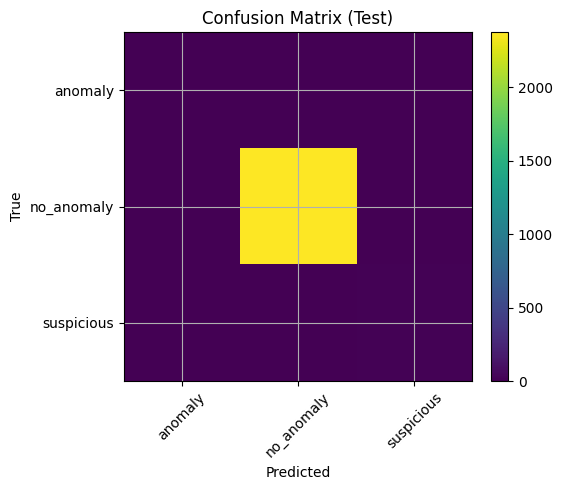

,y_true,y_pred
0,no_anomaly,no_anomaly
1,no_anomaly,no_anomaly
2,no_anomaly,no_anomaly
3,no_anomaly,no_anomaly
4,no_anomaly,no_anomaly
5,no_anomaly,no_anomaly
6,no_anomaly,no_anomaly
7,no_anomaly,no_anomaly
8,no_anomaly,no_anomaly
9,no_anomaly,no_anomaly



Note:
- Metric uses Macro-F1 to fairly weight all classes despite imbalance (as per assignment).
- Displayed the *first 5* test predictions, per instructions.


In [29]:
# Prepare X_test / y_test (label is expected to exist in test per assignment)
assert label_col in test.columns, "Test set does not include the label column."
X_test  = test[feature_cols].copy()
y_test  = test[label_col].copy()

# Predict once on test
y_pred = final_pipe.predict(X_test)

# Metric: Macro-F1 (multi-class per assignment)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print("=== Phase 5: Test Evaluation ===")
print("Macro-F1 (test):", round(macro_f1, 4))  # assignment metric for multi-class

# Detailed report
print("\nPer-class classification report (test):")
print(classification_report(y_test, y_pred))

# Confusion matrix (values)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
print("Confusion matrix (rows=true, cols=pred):\n", cm)

# Confusion matrix heatmap (matplotlib only)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Test)")
plt.colorbar(fraction=0.046, pad=0.04)
tick_labels = [str(x) for x in np.unique(y_test)]
plt.xticks(range(len(tick_labels)), tick_labels, rotation=45)
plt.yticks(range(len(tick_labels)), tick_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Show the first 5 predictions (as required)
first5 = (
    pd.DataFrame({
        "y_true": y_test.iloc[280:300].values,
        "y_pred": y_pred[280:300]
    })
)
display(first5)

print("\nNote:")
print("- Metric uses Macro-F1 to fairly weight all classes despite imbalance (as per assignment).")
print("- Displayed the *first 5* test predictions, per instructions.")
